In [226]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_openai import ChatOpenAI
ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",)
# model.invoke("Hello").content  

ChatGoogleGenerativeAI(model='models/gemini-1.5-flash', google_api_key=SecretStr('**********'), client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x00000229D29C8190>, default_metadata=(), model_kwargs={})

## 1. Importing and Setting Up Language Models
This section imports connectors for Google and OpenAI language models using LangChain. These connectors allow you to interact with powerful AI models for generating text or answering questions.
- `ChatGoogleGenerativeAI` and `ChatOpenAI` are classes that let you send prompts to Google Gemini and OpenAI models, respectively.
- The `model` object (created but not used here) would allow you to send a message and get a response from the AI.
- The commented line shows how you could invoke the model to get a response to a simple greeting.

# LangGraph + LangChain Agent: Detailed Walkthrough
This notebook demonstrates how to build an intelligent agent using [LangChain](https://python.langchain.com/) and [LangGraph](https://langchain-ai.github.io/langgraph/). The agent can classify user questions and route them to the right answering strategy: either using a local knowledge base (about India) or a general-purpose language model. The notebook covers every step, from loading documents and creating embeddings, to building a vector database, and finally constructing a decision-making workflow using LangGraph.
**Key Concepts Covered:**
- Using LLMs (Large Language Models) for both classification and answering questions
- Creating and searching a vector database (FAISS) for document retrieval
- Splitting large documents into manageable chunks for efficient retrieval
- Building a multi-step agent workflow with LangGraph, including routing logic
- Understanding how state and message history are managed in agent workflows
This notebook is heavily commented and includes markdown explanations for every major step.

In [227]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

## 2. Embeddings: Turning Text into Numbers
Embeddings are a way to represent text as a list of numbers (vectors) that capture the meaning of the text. This is essential for tasks like semantic search, where you want to find similar pieces of text based on meaning, not just keywords.
- `OpenAIEmbeddings` is a LangChain class that connects to OpenAI's embedding models.
- The `embeddings` object lets you convert any text into a high-dimensional vector. This is the foundation for building a searchable knowledge base.

In [228]:
len(embeddings.embed_query("Hello world!"))

3072

### Why Check the Embedding Length?
Every embedding model produces vectors of a fixed size (here, 3072 numbers). This size must match the configuration of the vector database (FAISS) you will create later. Checking the length ensures compatibility and helps avoid errors when storing and searching vectors.

In [229]:
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
import faiss
from langchain_community.vectorstores import FAISS
from langchain_community.docstore.in_memory import InMemoryDocstore

## 3. Document Loading and Vector Database Tools
This section imports tools for loading text files, splitting them into chunks, and storing them in a searchable vector database.
- `DirectoryLoader` and `TextLoader` help you load all `.txt` files from a folder as documents.
- `RecursiveCharacterTextSplitter` breaks large documents into smaller, overlapping chunks for efficient retrieval.
- `faiss` is a high-performance library for fast similarity search over vectors.
- `FAISS` (LangChain wrapper) makes it easy to use FAISS as a vector store for your document chunks.
- `InMemoryDocstore` keeps the original text of your documents in memory, so you can retrieve the actual content after searching.

In [230]:
loader = DirectoryLoader("Langgraph", glob="*.txt", loader_cls=TextLoader)

### Loading Documents from a Directory
Here, you use `DirectoryLoader` to automatically find and load all `.txt` files from the specified folder. Each file becomes a document object. This is the first step in building your knowledge base, as it brings your local data into the workflow for further processing.

In [231]:
docs = loader.load()

### What is in the `docs` Variable?
After running the loader, the `docs` variable contains a list of document objects, each representing the content of a `.txt` file from your folder. These objects are used as the raw material for further processing, such as splitting and embedding.

In [232]:
docs[0].page_content

"India: A Cultural and Economic Powerhouse\nKey Facts:\n- Capital: New Delhi\n- President: Droupadi Murmu (2022-present)\n- Prime Minister: Narendra Modi (2014-present)\n- Government Type: Federal Parliamentary Democratic Republic\n- Independence: August 15, 1947\n\nPolitical System:\n- Parliament consists of Lok Sabha (Lower House) and Rajya Sabha (Upper House)\n- Multi-party democracy with national and regional parties\n- Universal adult suffrage with voting age of 18\n- Independent judiciary with Supreme Court as highest court\n\nNotable Prime Ministers:\n- Jawaharlal Nehru (1947-1964)\n- Indira Gandhi (1966-1977, 1980-1984)\n- Rajiv Gandhi (1984-1989)\n- Atal Bihari Vajpayee (1998-2004)\n- Manmohan Singh (2004-2014)\n\nMajor Political Parties:\n- Bharatiya Janata Party (BJP)\n- Indian National Congress (INC)\n- Various regional parties\n\nStates and Union Territories:\n- 28 States with their own elected governments\n- 8 Union Territories administered by central government\n- Larges

### Inspecting Document Content
It's helpful to look at the content of the first loaded document to verify that your data has been loaded correctly. This step is useful for debugging and understanding what information will be available to your agent.

In [233]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
)

### Splitting Documents into Chunks
Large documents are split into smaller, overlapping chunks using `RecursiveCharacterTextSplitter`. This is important because language models and vector databases work best with short, focused pieces of text. Overlapping ensures that important context is not lost at the boundaries between chunks.

In [234]:
new_docs=text_splitter.split_documents(documents=docs)

### What is in `new_docs`?
After splitting, `new_docs` contains many small document chunks, each with a portion of the original text. This chunking is crucial for efficient and accurate retrieval, as it allows the system to find and return only the most relevant pieces of information in response to a query.

In [235]:
new_docs

[Document(metadata={'source': 'Langgraph\\file.txt'}, page_content='India: A Cultural and Economic Powerhouse\nKey Facts:\n- Capital: New Delhi\n- President: Droupadi Murmu (2022-present)\n- Prime Minister: Narendra Modi (2014-present)\n- Government Type: Federal Parliamentary Democratic Republic\n- Independence: August 15, 1947\n\nPolitical System:\n- Parliament consists of Lok Sabha (Lower House) and Rajya Sabha (Upper House)\n- Multi-party democracy with national and regional parties\n- Universal adult suffrage with voting age of 18\n- Independent judiciary with Supreme Court as highest court\n\nNotable Prime Ministers:\n- Jawaharlal Nehru (1947-1964)\n- Indira Gandhi (1966-1977, 1980-1984)\n- Rajiv Gandhi (1984-1989)\n- Atal Bihari Vajpayee (1998-2004)\n- Manmohan Singh (2004-2014)\n\nMajor Political Parties:\n- Bharatiya Janata Party (BJP)\n- Indian National Congress (INC)\n- Various regional parties'),
 Document(metadata={'source': 'Langgraph\\file.txt'}, page_content="Major Poli

In [236]:
doc_string = [doc.page_content for doc in new_docs]

In [237]:
doc_string

['India: A Cultural and Economic Powerhouse\nKey Facts:\n- Capital: New Delhi\n- President: Droupadi Murmu (2022-present)\n- Prime Minister: Narendra Modi (2014-present)\n- Government Type: Federal Parliamentary Democratic Republic\n- Independence: August 15, 1947\n\nPolitical System:\n- Parliament consists of Lok Sabha (Lower House) and Rajya Sabha (Upper House)\n- Multi-party democracy with national and regional parties\n- Universal adult suffrage with voting age of 18\n- Independent judiciary with Supreme Court as highest court\n\nNotable Prime Ministers:\n- Jawaharlal Nehru (1947-1964)\n- Indira Gandhi (1966-1977, 1980-1984)\n- Rajiv Gandhi (1984-1989)\n- Atal Bihari Vajpayee (1998-2004)\n- Manmohan Singh (2004-2014)\n\nMajor Political Parties:\n- Bharatiya Janata Party (BJP)\n- Indian National Congress (INC)\n- Various regional parties',
 "Major Political Parties:\n- Bharatiya Janata Party (BJP)\n- Indian National Congress (INC)\n- Various regional parties\n\nStates and Union Terr

In [238]:
index = faiss.IndexFlatL2(3072)
new_vector_store=FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={}
)


## 4. Creating a Vector Store with FAISS
A vector store is a special database that stores embeddings (vectors) for fast similarity search. FAISS is a high-performance library for this purpose. Here, you create a FAISS index that matches the embedding size (3072), and wrap it with LangChain's FAISS class to manage both the vectors and the original document text. This setup enables efficient retrieval of relevant document chunks based on semantic similarity.

In [239]:
new_vector_store.add_documents(new_docs)

['23fdf857-ed5b-461f-a555-49e6ddd730bc',
 '4667094c-5df5-4cee-9fa9-d82403047a07',
 'f1b1877b-c8e3-4263-8b6a-e41b29c59be2',
 'd06655c7-a9fa-4e2a-b0a3-0d638c1766dd',
 'e7e678a5-a1c4-423c-b66c-2197c1a541be']

### Populating the Vector Store
When you call `add_documents`, each document chunk is converted into an embedding (vector) and stored in the FAISS index. The original text is also saved in memory. This step makes your knowledge base searchable by meaning, not just by keywords.

In [240]:
retriever = new_vector_store.as_retriever(search_kwargs={"k": 1})

### Creating a Retriever
A retriever is an abstraction that lets you search the vector store for the most relevant document chunks given a query. Here, you configure it to return only the single best match (`k=1`). The retriever will be used later to fetch context for answering questions about India.

In [241]:
retriever.invoke("What is the capital of India?")[0].page_content

'India: A Cultural and Economic Powerhouse\nKey Facts:\n- Capital: New Delhi\n- President: Droupadi Murmu (2022-present)\n- Prime Minister: Narendra Modi (2014-present)\n- Government Type: Federal Parliamentary Democratic Republic\n- Independence: August 15, 1947\n\nPolitical System:\n- Parliament consists of Lok Sabha (Lower House) and Rajya Sabha (Upper House)\n- Multi-party democracy with national and regional parties\n- Universal adult suffrage with voting age of 18\n- Independent judiciary with Supreme Court as highest court\n\nNotable Prime Ministers:\n- Jawaharlal Nehru (1947-1964)\n- Indira Gandhi (1966-1977, 1980-1984)\n- Rajiv Gandhi (1984-1989)\n- Atal Bihari Vajpayee (1998-2004)\n- Manmohan Singh (2004-2014)\n\nMajor Political Parties:\n- Bharatiya Janata Party (BJP)\n- Indian National Congress (INC)\n- Various regional parties'

### Semantic Search in Action
By invoking the retriever with a question, you get the most relevant chunk of text from your knowledge base. This is called semantic search, because it finds information based on meaning, not just exact words. This is a key capability for building intelligent question-answering systems.

In [242]:
from pydantic import BaseModel, Field

## 5. Structured Output with Pydantic
When working with LLMs, it's often useful to get structured outputs (like JSON) instead of free-form text. `pydantic` is a library for defining data models with validation. Here, you use it to specify the exact format you want the LLM to return when classifying questions. This makes downstream processing much more reliable.

In [243]:
class TopicSelectionParser(BaseModel):
    Topic: str = Field(description="The topic selected")
    Reasoning: str = Field(description="The reasoning behind the topic selection")

### Defining a Structured Output Model
The `TopicSelectionParser` class defines the exact fields you want the LLM to return: a `Topic` and a `Reasoning`. This makes it easy to parse and validate the LLM's output, ensuring you always get the information you need in a predictable format.

In [244]:
from langchain.output_parsers import PydanticOutputParser

### Parsing LLM Output with PydanticOutputParser
`PydanticOutputParser` is a LangChain tool that takes your Pydantic model and ensures the LLM's output matches the expected structure. It also provides format instructions for the LLM, making it more likely to return valid, parseable data.

In [245]:
parser = PydanticOutputParser(pydantic_object=TopicSelectionParser)

### Format Instructions for the LLM
The parser can generate format instructions that tell the LLM exactly how to structure its output. This increases the reliability of downstream parsing and ensures the agent workflow receives data in the expected format.

In [246]:
parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"Topic": {"description": "The topic selected", "title": "Topic", "type": "string"}, "Reasoning": {"description": "The reasoning behind the topic selection", "title": "Reasoning", "type": "string"}}, "required": ["Topic", "Reasoning"]}\n```'

In [247]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.messages import HumanMessage, AIMessage
from typing import TypedDict , Annotated , Sequence
from langchain_core.messages import BaseMessage
import operator

## 6. Defining Agent State and Utility Functions
This section imports core LangChain and Python typing tools. The most important concept here is the definition of `AgentState`, which describes the shared memory (state) that is passed between nodes in the LangGraph workflow. This state keeps track of the conversation history and any intermediate results.

In [248]:
class AgentState(TypedDict):
    messages : Annotated[Sequence[BaseMessage], operator.add]

### Understanding AgentState and Message History
The `AgentState` class defines the structure of the state object passed between nodes. Here, `messages` is a list that accumulates all messages (user queries, classifications, answers) as the workflow progresses. Using `operator.add` ensures that new messages are appended, preserving the full conversation history for context-aware processing.

In [249]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

### Utility: Formatting Retrieved Documents
The `format_docs` function takes a list of document objects and joins their content into a single string. This is useful for preparing context to be fed into the language model during the retrieval-augmented generation (RAG) process.

In [250]:
# supervisor function
def function_1(state: AgentState):
    question=state['messages'][-1]
    print("Question",question)
    template="""
    Your task is to classify the given user query into one of the following categories: [India,Not Related]. 
    Only respond with the category name and nothing else.

    User query: {question}
    {format_instructions}
    
    """
    prompt = PromptTemplate(
        template=template,
        input_variables=["question"],
        partial_variables={"format_instructions": parser.get_format_instructions()}
    )
    # model = ChatGoogleGenerativeAI(model="gemini-1.5-flash")
    model = ChatOpenAI()
    chain = prompt | model | parser
    response = chain.invoke({"question":question})
    
    print("Parsed response:", response)
    
    return {"messages": [response.Topic]}

## 7. Supervisor Node: Classifying the User Query
The `function_1` (Supervisor) node is the first step in the workflow. It examines the latest message (the user's question) and uses an LLM to classify it as either 'India' or 'Not Related'.
- The prompt template instructs the LLM to return only the category name, using format instructions for structured output.
- The result is parsed and appended to the message history in the state, which will be used by the router to decide the next step.

In [251]:
state={'messages': ["Who is mrbeast?"]}
function_1(state)

Question Who is mrbeast?
Parsed response: Topic='Not Related' Reasoning='The user query does not pertain to the country of India.'


{'messages': ['Not Related']}

In [252]:
state={'messages': ["What is gdp of India?"]}
function_1(state)

Question What is gdp of India?
Parsed response: Topic='India' Reasoning='The user query specifically mentions India'


{'messages': ['India']}

In [270]:
# Rag function
def function_2(state: AgentState):
    print("-> Rag called ->")

    question=state['messages'][0]

    prompt=PromptTemplate(
        template="""You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:""",
        
        input_variables=['context', 'question']
    )
    
    # model = ChatGoogleGenerativeAI(model="gemini-1.5-flash")
    model = ChatOpenAI(model="gpt-4o")
    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | model
        | StrOutputParser()
    )
    result = rag_chain.invoke(question)
    return  {"messages": [result]}


## 8. RAG Node: Retrieval-Augmented Generation
The `function_2` node is responsible for answering questions classified as 'India'. It works by:
- Taking the original user question from the state.
- Using the retriever to find the most relevant chunk(s) from your local knowledge base.
- Feeding both the question and the retrieved context into an LLM, which generates a concise answer based only on the provided context.
This approach ensures that answers are grounded in your specific data, not just the LLM's general knowledge.

In [271]:
# LLm function
def function_3(state: AgentState):
    print("-> LLM Call ->")
    question = state["messages"][0]
    
    # Normal LLM call
    complete_query = "Anwer the follow question with you knowledge of the real world. Following is the user question: " + question
    # model = ChatGoogleGenerativeAI(model="gemini-1.5-flash")
    model = ChatOpenAI(model="gpt-4o")
    response = model.invoke(complete_query)
    return {"messages": [response.content]}

## 9. LLM Node: General-Purpose Answering
The `function_3` node is used for questions not related to India. It simply takes the original user question and passes it to a general-purpose LLM (like GPT-4o or Gemini). The answer is based on the model's broad, pre-trained knowledge, not your local documents.

In [273]:
def router(state:AgentState):
    print("-> Router called ->")

    last_message=state['messages'][-1]
    print("Last message:", last_message)
    if "india" in last_message.lower():
        return "Rag"
    else:
        return "llm-call"

## 10. Router: Decision Logic for Workflow
The `router` function examines the last message in the state (the classification result from the Supervisor). Based on whether the topic is 'India' or not, it decides which node to run next: the RAG node for India-related questions, or the LLM node for everything else. This conditional routing is what makes the agent intelligent and adaptive.

In [256]:
from langgraph.graph import StateGraph,END

## 11. Building the Workflow Graph
LangGraph lets you define a workflow as a directed graph, where each node is a function (like Supervisor, RAG, or LLM) and edges define the flow of execution. `StateGraph` is the main class for building such workflows, and `END` marks the termination point.

In [257]:
workflow = StateGraph(AgentState) 

### Adding Nodes and Edges to the Workflow
You add each function (Supervisor, RAG, LLM) as a node in the workflow graph. Then, you define the entry point (where execution starts) and add edges to control the flow based on the router's decision. This modular design makes it easy to extend or modify the agent's behavior.

In [258]:
workflow.add_node("Supervisor",function_1) 

In [259]:
workflow.add_node("Rag",function_2)

In [260]:
workflow.add_node("llm-call",function_3)

In [261]:
workflow.set_entry_point("Supervisor")

In [262]:
workflow.add_conditional_edges(
    "Supervisor",
    router,
    {
        "Rag": "Rag",
        "llm-call": "llm-call",
    }
)

In [263]:
workflow.add_edge('Rag',END)

In [264]:
workflow.add_edge('llm-call',END)

In [265]:
app=workflow.compile()

## 12. Compiling and Running the Agent
Compiling the workflow turns your graph definition into an executable application. The resulting `app` object can be invoked with a user question, and it will automatically route the query, retrieve context, and generate an answer according to the logic you defined.

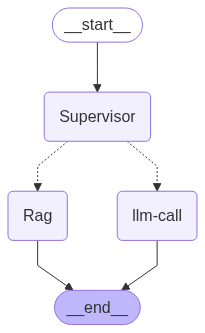

In [266]:
app

In [267]:
app.invoke({"messages": ["Who is president of India?"]})

Question Who is president of India?
Parsed response: Topic='India' Reasoning='The user query specifically asks about the president of India.'
-> Router called ->
Last message: India
-> Rag called ->


{'messages': ['Who is president of India?',
  'India',
  'The president of India is Droupadi Murmu (2022-present).']}

### Example: Asking About the President of India
When you invoke the app with a question like "Who is president of India?":
1. The Supervisor classifies the question as 'India'.
2. The router sends the query to the RAG node, which retrieves relevant context from your local documents and generates an answer.
3. The final answer is returned in the state.

In [268]:
app.invoke({"messages": ["What is the capital of australia?"]})

Question What is the capital of australia?
Parsed response: Topic='Not Related' Reasoning='The user query is not related to India.'
-> Router called ->
Last message: Not Related
-> LLM Call ->


{'messages': ['What is the capital of australia?',
  'Not Related',
  'The capital of Australia is Canberra.']}

### Example: Asking About Australia
When you ask about a topic not related to India (e.g., "What is the capital of Australia?"), the Supervisor classifies it as 'Not Related', and the router sends the query to the LLM node. The answer is generated using the model's general knowledge, not your local documents.

In [272]:
app.invoke({"messages":["Who is the president of usa ?"]})["messages"][-1]

Question Who is the president of usa ?
Parsed response: Topic='Not Related' Reasoning='The user query is not related to India'
-> Router called ->
Last message: Not Related
-> LLM Call ->


'As of June 2024, the President of the United States is Joe Biden.'

## Summary and Next Steps
This notebook demonstrates how to combine LangChain and LangGraph to build a smart, multi-step agent that can classify questions, retrieve relevant context, and generate answers using both local and general knowledge. You can extend this workflow by adding more categories, more complex routing logic, or integrating additional data sources.